In [55]:
%pip install tensorflow --quiet
%pip install scikit-learn --quiet


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [56]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [57]:
path = '/Users/anoguera/Documents/GitHub/WasteRecognition-CV'

In [58]:
def load_images_and_labels(base_dir):
    images = []
    labels = []
    class_names = ['Cardboard', 'Food Organics', 'Glass', 'Paper', 'Metal', 'Plastic', 'Textile Trash']
    class_names.sort()
    label_dict = {name: index for index, name in enumerate(class_names)}

    for name in class_names:
        dir_path = os.path.join(base_dir, name)
        for image_file in os.listdir(dir_path):
            if image_file.lower().endswith('.jpg'):  # Procesar solo archivos JPG
                image_path = os.path.join(dir_path, image_file)
                image = Image.open(image_path).convert("RGB")
                image = ImageOps.fit(image, (224, 224), Image.Resampling.LANCZOS)
                image_array = np.asarray(image)

                # Normalizar la imagen directamente mientras se convierte a float
                normalized_image_array = (image_array.astype(np.float32) / 127.5) - 1

                images.append(normalized_image_array)
                labels.append(label_dict[name])

    return np.array(images), np.array(labels), class_names

In [59]:
images, labels, class_names = load_images_and_labels(f'{path}/RealWaste')

In [62]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelar los pesos del modelo base para no modificarlos durante el entrenamiento
for layer in base_model.layers:
    layer.trainable = False

# Añadir nuevas capas para la clasificación de basura
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
outputs = Dense(len(class_names), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)
model.compile(optimizer=Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [63]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [65]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=8)

Epoch 1/100
382/382 ━━━━━━━━━━━━━━━━━━━━ 118s 308ms/step - accuracy: 0.3515 - loss: 1.6885 - val_accuracy: 0.3386 - val_loss: 1.5637
Epoch 2/100
382/382 ━━━━━━━━━━━━━━━━━━━━ 121s 317ms/step - accuracy: 0.4110 - loss: 1.5003 - val_accuracy: 0.4092 - val_loss: 1.4651
Epoch 3/100
382/382 ━━━━━━━━━━━━━━━━━━━━ 118s 310ms/step - accuracy: 0.4121 - loss: 1.4639 - val_accuracy: 0.4418 - val_loss: 1.4374
Epoch 4/100
382/382 ━━━━━━━━━━━━━━━━━━━━ 114s 300ms/step - accuracy: 0.4486 - loss: 1.3917 - val_accuracy: 0.4405 - val_loss: 1.4170
Epoch 5/100
382/382 ━━━━━━━━━━━━━━━━━━━━ 118s 309ms/step - accuracy: 0.4529 - loss: 1.3747 - val_accuracy: 0.4275 - val_loss: 1.6066
Epoch 6/100
382/382 ━━━━━━━━━━━━━━━━━━━━ 116s 304ms/step - accuracy: 0.4435 - loss: 1.3764 - val_accuracy: 0.4431 - val_loss: 1.3617
Epoch 7/100
382/382 ━━━━━━━━━━━━━━━━━━━━ 117s 307ms/step - accuracy: 0.4671 - loss: 1.3357 - val_accuracy: 0.4458 - val_loss: 1.4150
Epoch 8/100
382/382 ━━━━━━━━━━━━━━━━━━━━ 119s 310ms/step - accuracy: 

24/24 - 19s - 807ms/step - accuracy: 0.5490 - loss: 1.4537
Test accuracy: 0.5490196347236633


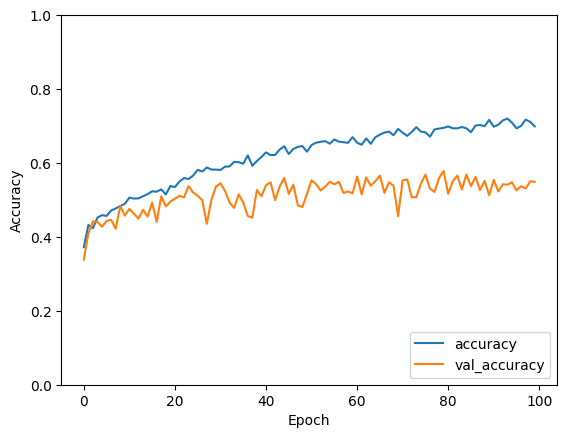

In [66]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc}")

In [67]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 18s 755ms/step - accuracy: 0.5438 - loss: 1.5015
Test Loss: 1.4536848068237305
Test Accuracy: 0.5490196347236633


In [68]:
y_pred = model.predict(X_test)
# Si las predicciones son probabilísticas (por ejemplo, softmax de salida), obtener la clase predicha como la de mayor probabilidad
y_pred_classes = np.argmax(y_pred, axis=1)  # Esto supone que `model.predict` devuelve un array de probabilidades por clase

24/24 ━━━━━━━━━━━━━━━━━━━━ 24s 901ms/step


In [69]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Calcular precisión, recall y f1-score
print(classification_report(y_test, y_pred_classes, target_names=class_names))

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Calcular la precisión de manera alternativa
print(f"Accuracy: {accuracy_score(y_test, y_pred_classes)}")

               precision    recall  f1-score   support

    Cardboard       0.45      0.47      0.46       116
Food Organics       0.95      0.52      0.67        77
        Glass       0.43      0.60      0.50        81
        Metal       0.64      0.73      0.69       161
        Paper       0.54      0.30      0.38        97
      Plastic       0.51      0.67      0.58       171
Textile Trash       0.54      0.23      0.32        62

     accuracy                           0.55       765
    macro avg       0.58      0.50      0.52       765
 weighted avg       0.57      0.55      0.54       765

Confusion Matrix:
[[ 55   0  10  10  14  26   1]
 [  0  40   1   4   1  25   6]
 [  2   0  49  10   0  20   0]
 [  7   1  12 118   3  19   1]
 [ 34   0   5  18  29   8   3]
 [ 10   0  25  16   4 115   1]
 [ 13   1  12   7   3  12  14]]
Accuracy: 0.5490196078431373


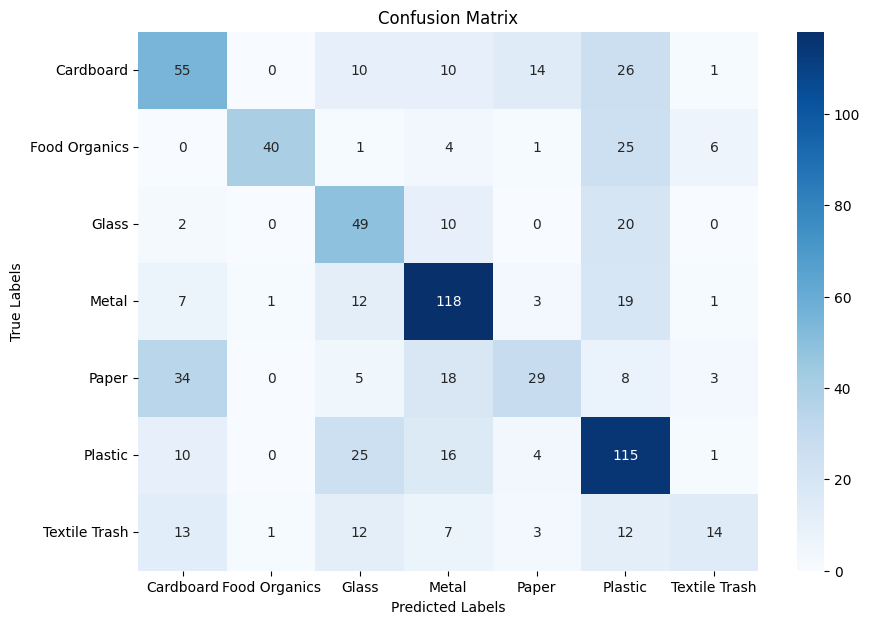

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [71]:
X_val, y_val, class_names = load_images_and_labels(f'{path}/Test2')

In [72]:
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step - accuracy: 0.3000 - loss: 4.4582
Test Loss: 4.4582200050354
Test Accuracy: 0.30000001192092896


In [73]:
y_pred = model.predict(X_val)
# Si las predicciones son probabilísticas (por ejemplo, softmax de salida), obtener la clase predicha como la de mayor probabilidad
y_pred_classes = np.argmax(y_pred, axis=1)  # Esto supone que `model.predict` devuelve un array de probabilidades por clase

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step


In [74]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Calcular precisión, recall y f1-score
print(classification_report(y_val, y_pred_classes, target_names=class_names))

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_val, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Calcular la precisión de manera alternativa
print(f"Accuracy: {accuracy_score(y_val, y_pred_classes)}")

               precision    recall  f1-score   support

    Cardboard       0.00      0.00      0.00         0
Food Organics       0.33      0.20      0.25         5
        Glass       0.00      0.00      0.00         0
        Metal       1.00      0.20      0.33         5
        Paper       0.67      0.40      0.50         5
      Plastic       0.67      0.40      0.50         5
Textile Trash       0.00      0.00      0.00         0

     accuracy                           0.30        20
    macro avg       0.38      0.17      0.23        20
 weighted avg       0.67      0.30      0.40        20

Confusion Matrix:
[[0 0 0 0 0 0 0]
 [2 1 0 0 0 0 2]
 [0 0 0 0 0 0 0]
 [0 1 0 1 0 0 3]
 [0 0 0 0 2 1 2]
 [0 1 1 0 1 2 0]
 [0 0 0 0 0 0 0]]
Accuracy: 0.3


/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


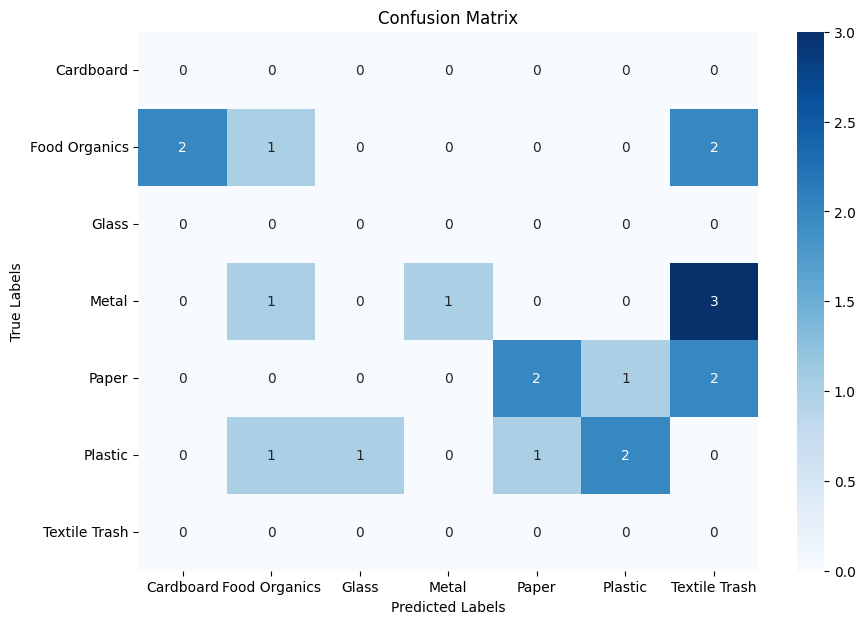

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()